In [51]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

# Загружаем данные по 6 рядам

In [52]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

# Построим графики рядов

In [53]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

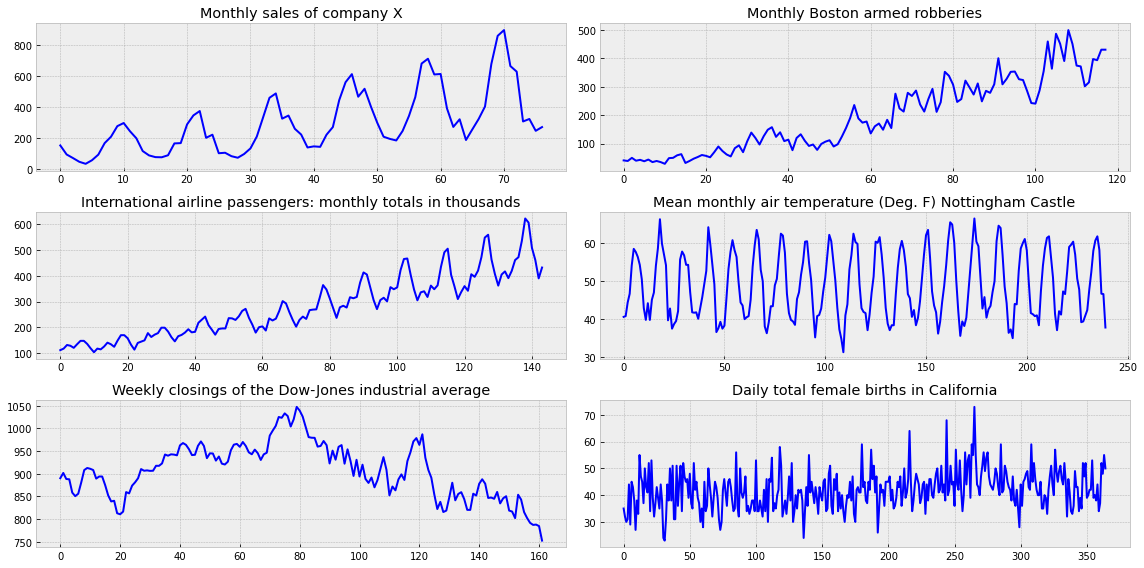

In [54]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [62]:
# Функция для построения графиков автокорреляции и частичной автокорреляция
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    #test_stationarity2(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        #print((i+1),'.',key)
        ts_ax.set_title((str(i+1)) + '. ' + key + ' (Original)')
        #print((i+1),'.',key)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm')

        plt.tight_layout()
    return

# Рассчитаем  p-value и построим графики коррелляции по 6 рядам

Results of Dickey-Fuller Test: p-value
1 . Monthly sales of company X
0.9888894205170052
2 . Monthly Boston armed robberies
0.9942775638057232
3 . International airline passengers: monthly totals in thousands
0.9918802434376411
4 . Mean monthly air temperature (Deg. F) Nottingham Castle
0.016989030222608986
5 . Weekly closings of the Dow-Jones industrial average
0.6224548515589742
6 . Daily total female births in California
5.2434129901498554e-05
p-value  по 6 рядам: [0.9889, 0.9943, 0.9919, 0.017, 0.6225, 0.0001]


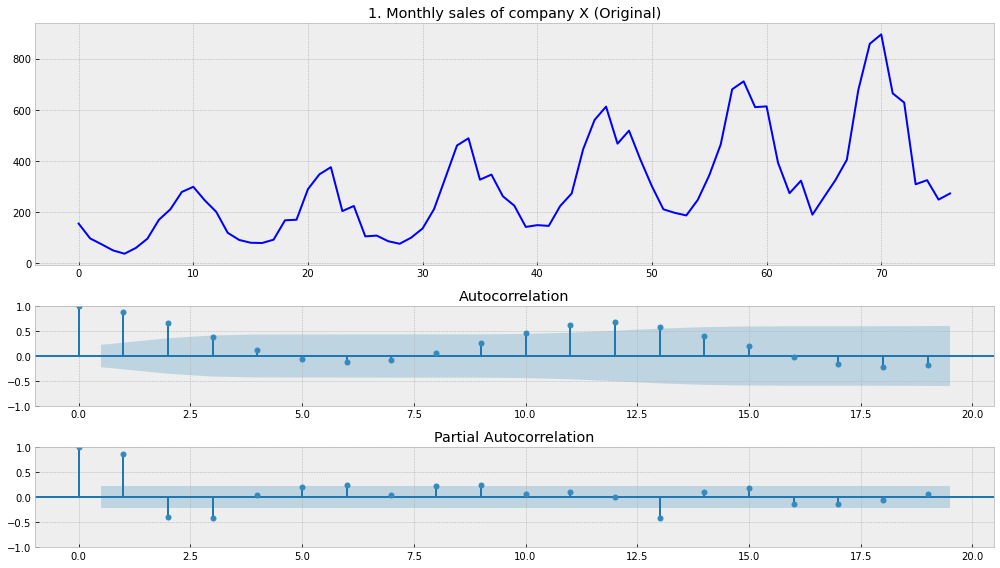

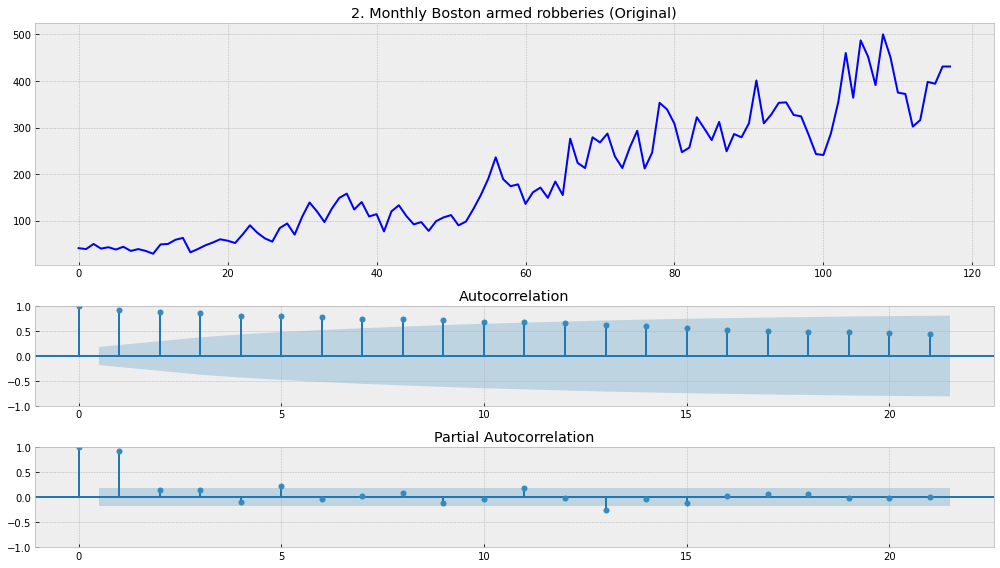

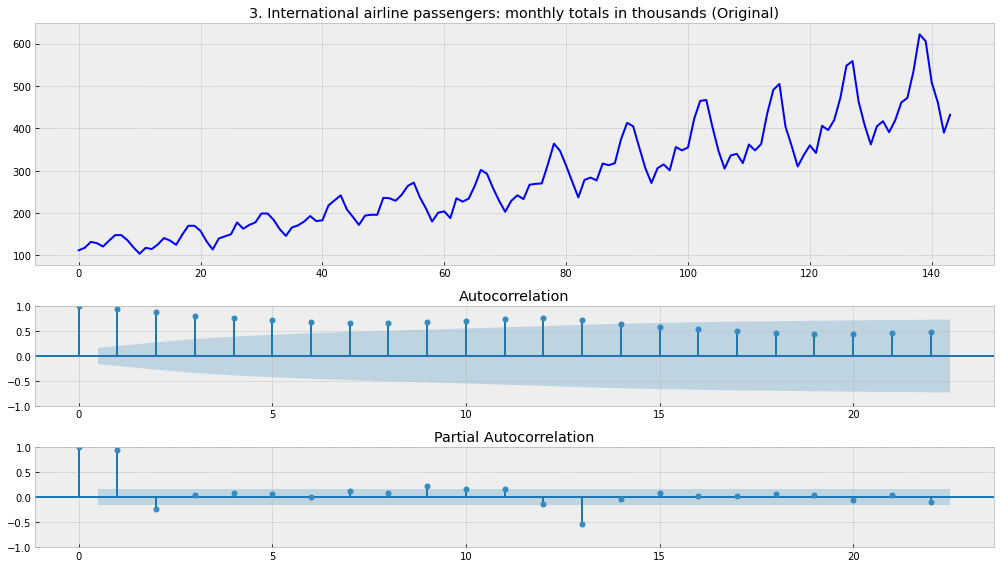

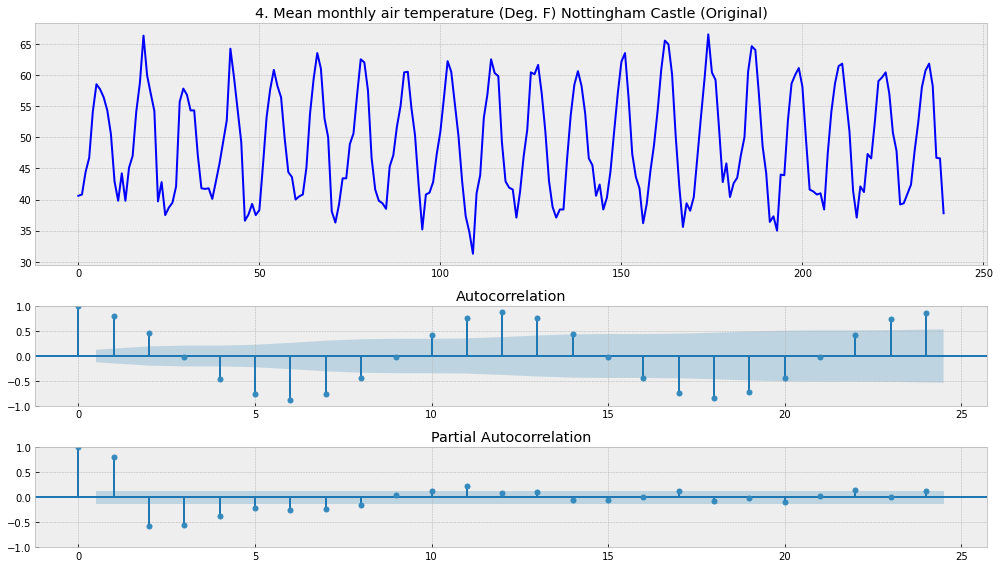

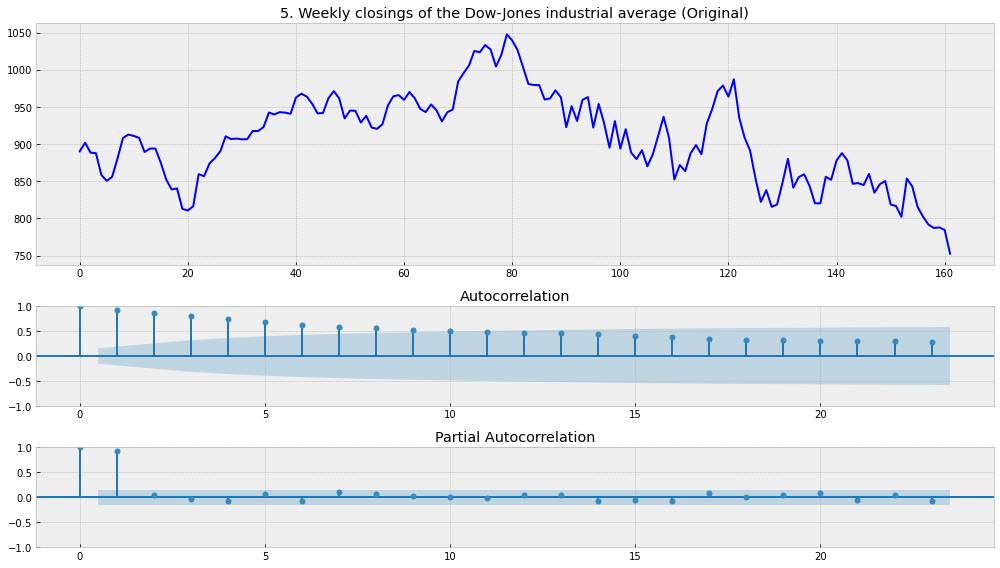

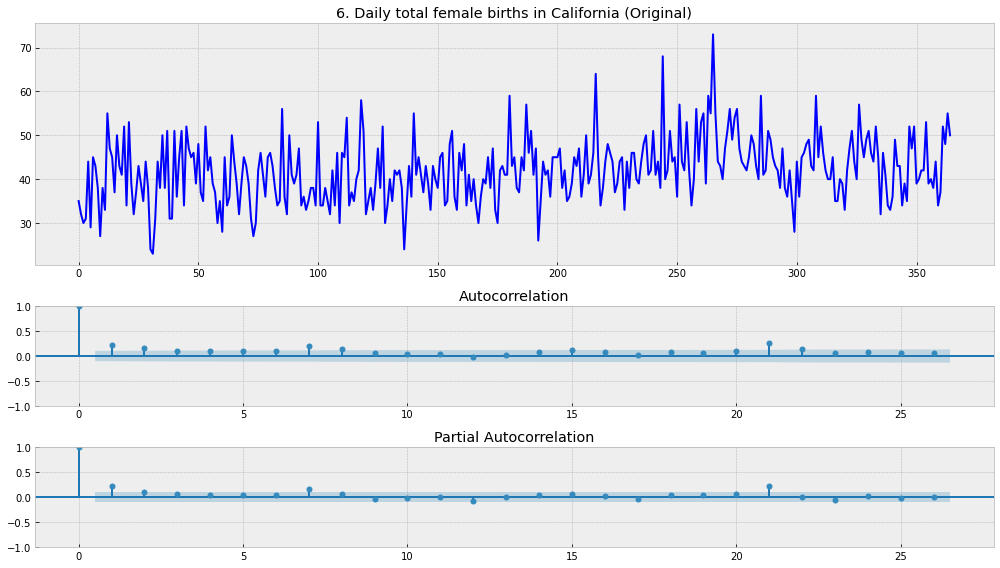

In [56]:
df0=[]
print('Results of Dickey-Fuller Test: p-value')
for i, key in enumerate(all_series.keys()):
    series = all_series[key]
    print((i+1),'.',key)
    #print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[1], index=['p-value'])
    print(dfoutput[0])
    df =round(dftest[1],4)
    df0.append(df)
    tsplot(series)
print('p-value  по 6 рядам:',df0)

# Добавим 3 варианта преобразования рядов:
1. Уберем изменение дисперсии при помощи преобразования Бокса-Кокса
2. Наличие сильного тренда уберем дифференцированием
3. Влияние сезонности уберем вычитанием значений с лагом 12 месяцев
# и рассчитаем p-value при различных вариантах

In [57]:
df1=[]
def NewRow():
    for i, key in enumerate(all_series.keys()):
        series = all_series[key]
        if i in (0,1,3,4,5):
            series = boxcox(series, 0) # преобразование Бокса-Кокса
            series = np.diff(series, 1) # диффренцирование
        if i == 2:
            series = boxcox(series, 0)
            series = np.diff(series, 1)    
            a,b = series[12:],series[:-12]
            series=[a - b for a, b in zip(a, b)]# вычитание сезонности (с лагом 12 месяцев)
        dftest = adfuller(series, autolag='AIC')
        #dfoutput = pd.Series(dftest[1], index=['p-value'])
        df =round(dftest[1],4)
        df1.append(df)
    print('Стало p-value  по 6 рядам:',df1)
    print('Было p-value  по 6 рядам:',df0)
    df10=[df1 - df0 for df1, df0 in zip(df1, df0)]
    print('Изменение p-value  по 6 рядам:',df10)
NewRow()

Стало p-value  по 6 рядам: [0.024, 0.0, 0.0002, 0.0, 0.0, 0.0]
Было p-value  по 6 рядам: [0.9889, 0.9943, 0.9919, 0.017, 0.6225, 0.0001]
Изменение p-value  по 6 рядам: [-0.9649, -0.9943, -0.9917, -0.017, -0.6225, -0.0001]


Наилучшие результаты получаются при последовательном преобразовании Бокса-Кокса и дифференцировании рядов, 

а для 3 ряда дополнительно применим вычитание сезонности.

При этом 4 и 6 ряды изначально уже были стационарными (p-value < 0.05)

# Построим итоговые значения теста Dickey-Fuller и графики по 6 рядам

In [103]:
# все показатели теста Dickey-Fuller
def test_stationarity2(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        df =round(dftest[1],4)
    df1.append(df)
    print(dfoutput)

In [104]:
# Функция для построения графиков автокорреляции и частичной автокорреляция
def tsplot2(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity2(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title((str(i+1)) + '. ' + key + ' (Original)')
        #print((i+1),'.',key)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm')

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
1 . Monthly sales of company X
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64
Стало p-value  по 6 рядам: [0.024]
2 . Monthly Boston armed robberies
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64
Стало p-value  по 6 рядам: [0.024, 0.0]
3 . International airline passengers: monthly totals in thousands
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of O

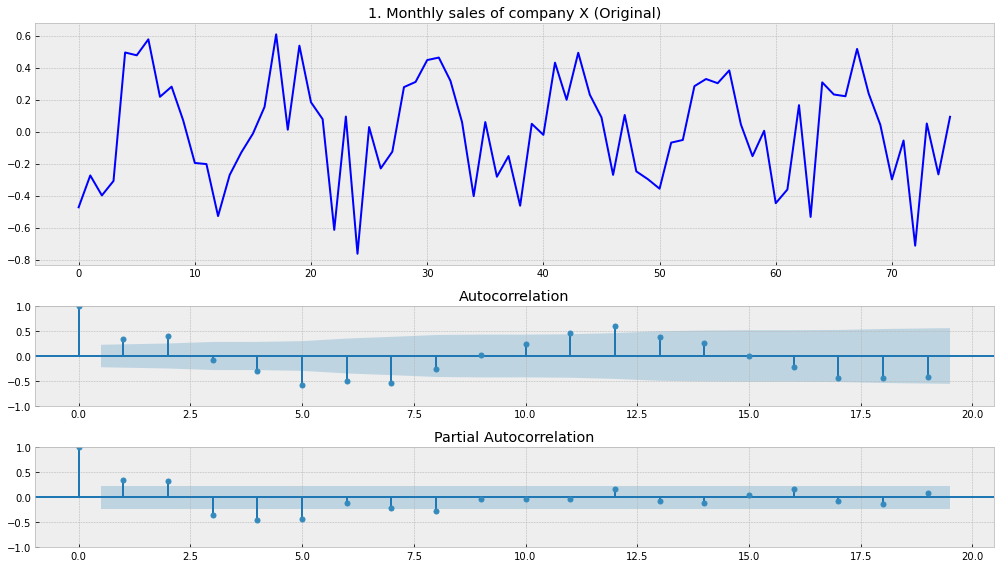

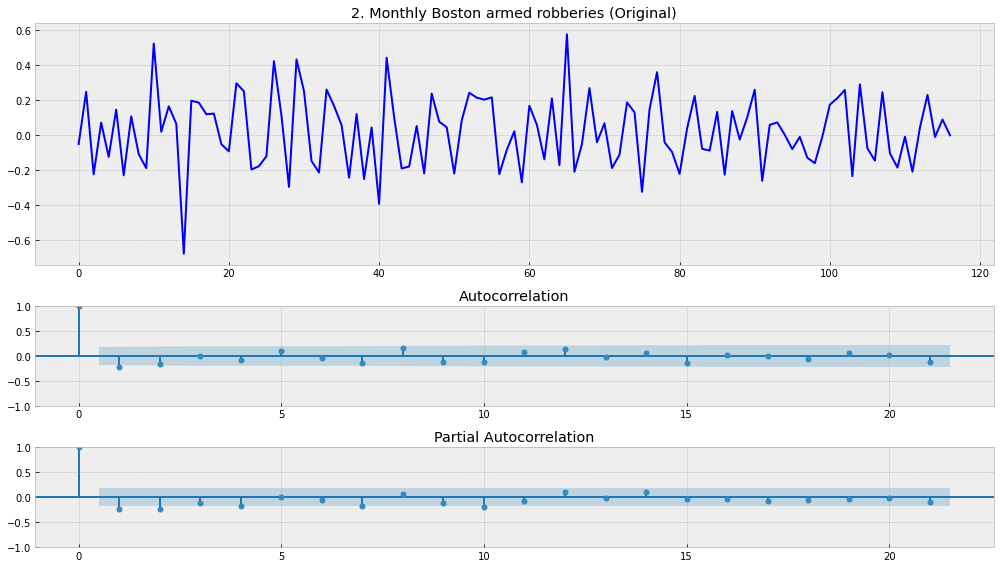

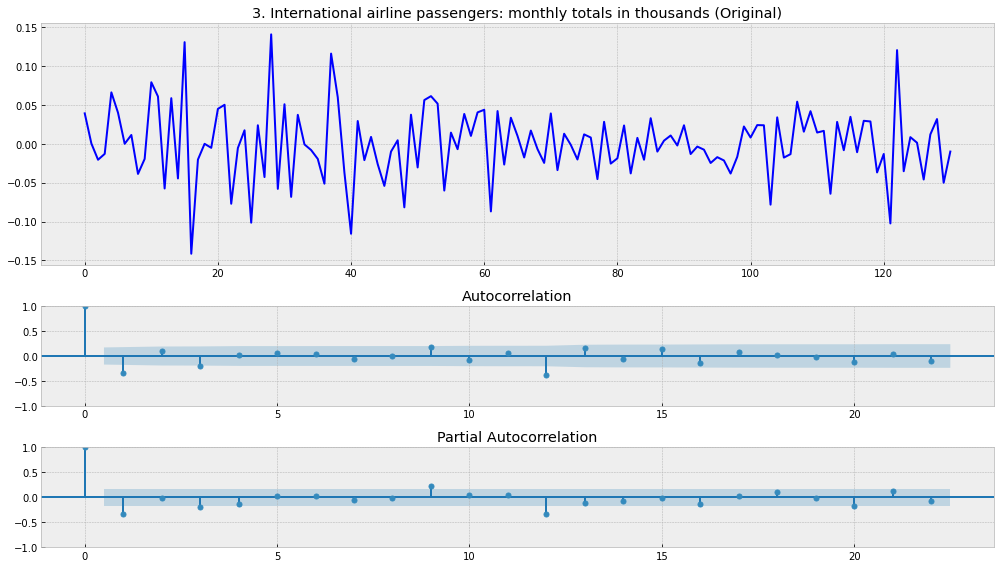

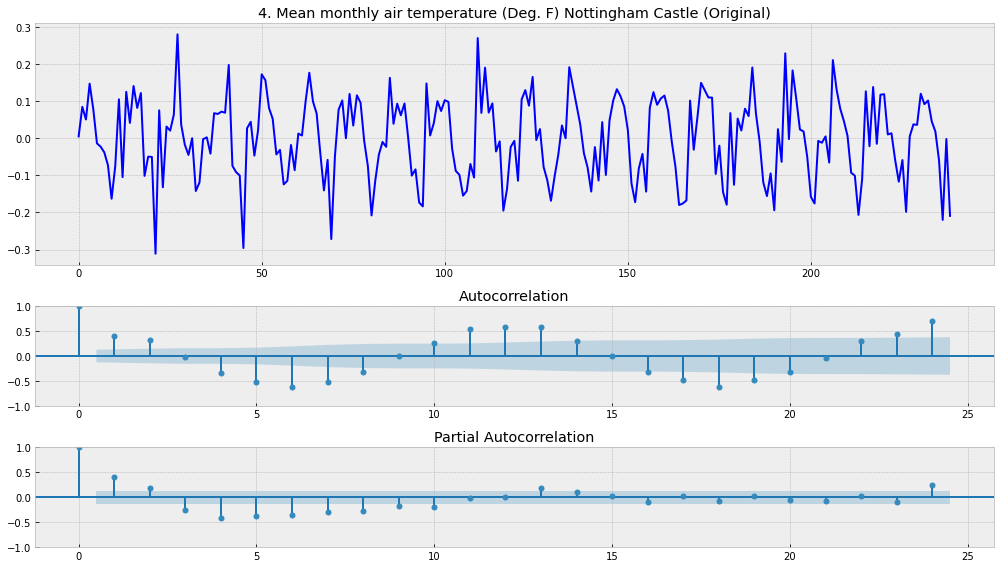

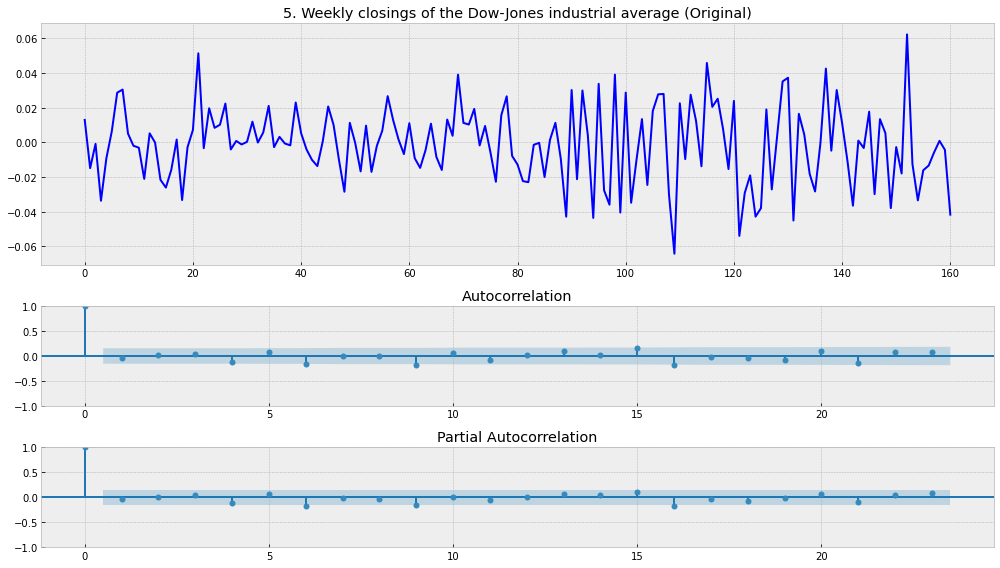

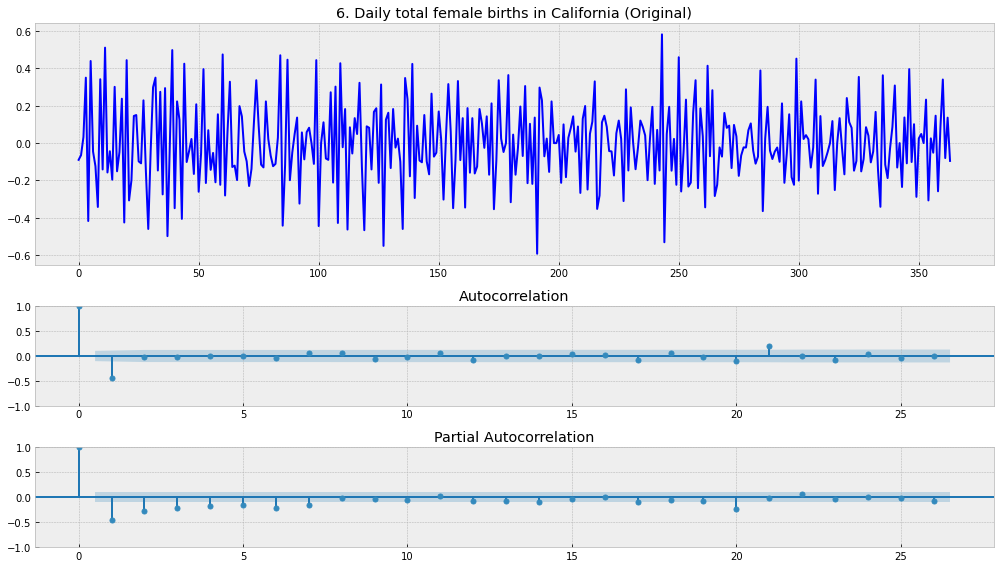

In [105]:
# Итоговые ряды
df1=[]
print('Results of Dickey-Fuller Test:')
for i, key in enumerate(all_series.keys()):
    series = all_series[key]
    print((i+1),'.',key)
    if i in (0,1,3,4,5):
        series = boxcox(series, 0) # преобразование Бокса-Кокса
        series = np.diff(series, 1) # диффренцирование
    #tsplot2(series)
    if i == 2:
        series = boxcox(series, 0)
        series = np.diff(series, 1)    
        a,b = series[12:],series[:-12]
        series=[a - b for a, b in zip(a, b)]# вычитание сезонности (с лагом 12 месяцев)
    tsplot2(series)
    print('Стало p-value  по 6 рядам:',df1)

# Теперь тест Дики-Фуллера и графики коррелограмм подтверждают гипотезу о стационарности рядов!
(есть только некоторый разброс значений в 1 и 4 графиках)